In [320]:
%cd /home/druhe/rail1/src/cnf

/home/druhe/rail1/src/cnf


In [321]:
import torch
import math
torch.set_default_dtype(torch.float64)
from algebra.cliffordalgebra import CliffordAlgebra

ca = CliffordAlgebra((-1, 1))

In [322]:
x = torch.tensor([0, 1])
ct = torch.tensor([1, 0])

In [345]:


c = 1
v = -0.5

eta = torch.arctanh(torch.tensor(v / c))

In [346]:
# blades=(
#         torch.tensor([1, 2], dtype=torch.long),
#         torch.tensor([0, 1, 2, 3], dtype=torch.long),
#         torch.tensor([1, 2], dtype=torch.long),
#     )
x_c = ca.embed_grade(x, 1)
ct_c = ca.embed_grade(ct, 1)

b = ca.geometric_product(
    x_c,
    ct_c,
    # blades=(
    #     torch.tensor([1, 2], dtype=torch.long),
    #     torch.tensor([0, 1, 2, 3], dtype=torch.long),
    #     torch.tensor([1, 2], dtype=torch.long),
    # ),
)

B = eta * b / 2

In [347]:
rotor = ca.exponential(B, truncate=20)

In [348]:
ca.rho(rotor, x_c)

tensor([0.0000, 0.5774, 1.1547, 0.0000])

In [349]:
gamma = 1 / math.sqrt(1 - v ** 2)

In [350]:
ct_prime = gamma * (x[0] - v * x[1])
x_prime = gamma * (x[1] - v * x[0])



In [351]:
x_prime

tensor(1.1547)

In [352]:
SHAPE = (128, 128)

xx = torch.linspace(-1, 1, SHAPE[0])
tt = torch.linspace(-1, 1, SHAPE[1])
grid = torch.stack(torch.meshgrid(xx, tt, indexing='xy'), dim=-1).reshape(-1, 2)

In [353]:
grid_c = ca.embed_grade(grid, 1)

In [354]:
boosted_grid = ca.rho(rotor, grid_c)
boosted_grid = ca.get_grade(boosted_grid, 1)

torch.Size([16384, 2]) torch.Size([16384, 2])


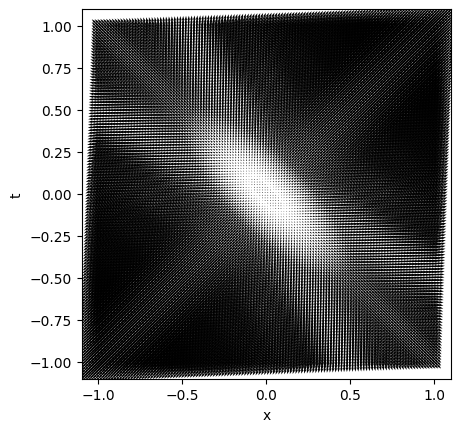

In [355]:
import matplotlib.pyplot as plt

def quiver(ax, grid, v):
    print(grid.shape, v.shape)
    v = v.reshape(-1, 2)
    grid = grid.reshape(-1, 2)
    ax.quiver(grid[:, 0], grid[:, 1], v[:, 0], v[:, 1], scale=32)
    plt.xlabel('x')
    plt.ylabel('t')


fig, ax = plt.subplots()
quiver(ax, grid, boosted_grid)
ax.set_aspect('equal')

plt.show()



In [356]:
v = torch.tensor([0.1, 0.5])
v = v[None].repeat(len(grid), 1)

# v = torch.randn(len(grid), 2) * 0.25
u = torch.cos(grid[:, 0] * math.pi) * torch.cos(grid[:, 1] * math.pi)
v = torch.sin(grid[:, 0] * math.pi) * torch.sin(grid[:, 1] * math.pi)
v = torch.stack([u, v], dim=-1)
v_c = ca.embed_grade(v, 1)

torch.Size([16384, 2]) torch.Size([16384, 2])


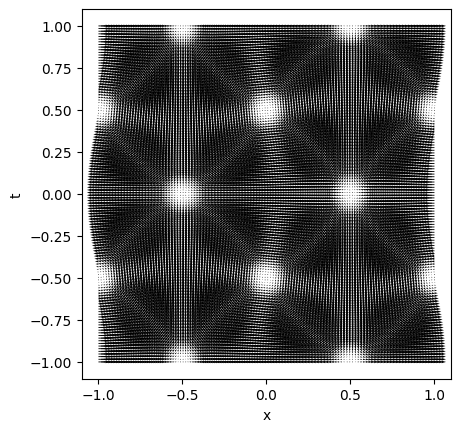

In [357]:
fig, ax = plt.subplots()
quiver(ax, grid, v)
ax.set_aspect('equal')

In [358]:
import torch.nn.functional as F

shape = (*SHAPE, 2)

def boost_vector_field(grid_c, v, n, N, B):

    B_inv = ca.inverse(B)
    grid_inv_c = ca.rho(B_inv, grid_c)
    grid_inv = ca.get_grade(grid_inv_c, 1)

    grid_inv = grid_inv.reshape(1, *SHAPE, 2)
    v = v.t().reshape(1, 2, *SHAPE)
    # print(grid_inv.min())
    z = F.grid_sample(v, grid_inv, align_corners=True)
    z = z.permute(0, 2, 3, 1).squeeze(0)

    # print('hi')
    # print(v.reshape(*shape)[16, 16])
    # print(z.reshape(*shape)[16, 16])

    z_c = ca.embed_grade(z, 1)
    z_c_tr = ca.rho(B, z_c)
    
    z_tr = ca.get_grade(z_c_tr, 1)
    # print(z_tr.reshape(*shape)[16, 16])
    

    return z_tr.reshape(-1, 2), grid_inv

In [359]:
result, grid_inv = boost_vector_field(grid_c, v, None, None, rotor)


In [360]:
# grid_inv.view(33, 33, 2)[16, 16]

In [361]:
result.norm(dim=-1).max()

tensor(1.2908)

torch.Size([16384, 2]) torch.Size([16384, 2])


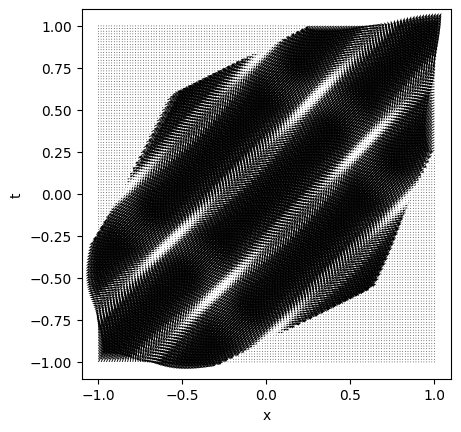

In [362]:
fig, ax = plt.subplots()
quiver(ax, grid, result)
ax.set_aspect('equal')

In [369]:
crop_size = 44
crop_slice = slice(SHAPE[0] // 2 - crop_size // 2, SHAPE[0] // 2 + crop_size // 2)


v_cropped = v.reshape(128, 128, 2)[crop_slice, crop_slice]
result_cropped = result.reshape(128, 128, 2)[crop_slice, crop_slice]
grid_reshaped = grid.reshape(128, 128, 2)[crop_slice, crop_slice]


torch.Size([44, 44, 2]) torch.Size([44, 44, 2])
torch.Size([44, 44, 2]) torch.Size([44, 44, 2])


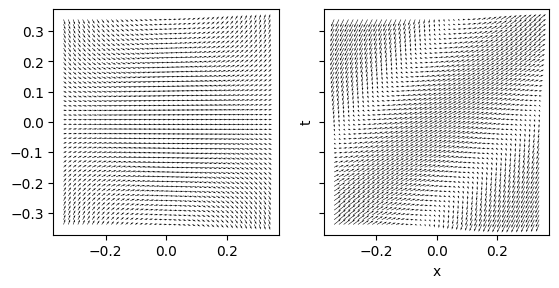

In [370]:
fig, ax = plt.subplots(ncols=2, sharey=True)
quiver(ax[0], grid_reshaped, v_cropped)
quiver(ax[1], grid_reshaped, result_cropped)
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
